## SV anaylsis
#### This analysis is to compare SV detected with two cattle genome builds from the same individual.
#### The objective is to investigate the effect of genome builds in sv calling.

In [1]:
#set working directory
setwd('/nfs/nas12.ethz.ch/fs1201/green_groups_tg_public/data/fang/Nanopore/sv_two_assembly/sv_ngmlr')

In [2]:
#Leonhard
.libPaths('/cluster/work/pausch/fang/bin/R/3.5')
library(ggplot2)
library(data.table)
library(dplyr)
library(ggpubr)
library(patchwork)

#Euler
#.libPaths('/cluster/home/fangzi/R')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: magrittr


In [3]:
#read the data
Angus=fread('angus_variants_ngmlr.csv')
UCD=fread('UCD_variants_ngmlr.csv')

In [4]:
#split the annotation column (CSQ) by '|'
t=Angus[,c(1:9)]
#head(t)
Angus=t[, c("Allele","Consequence","IMPACT","SYMBOL","Gene","Feature_type","Feature","BIOTYPE","EXON","INTRON","HGVSc","HGVSp","cDNA_position","CDS_position","Protein_position","Amino_acids","Codons","Existing_variation","DISTANCE","STRAND","FLAGS","SYMBOL_SOURCE","HGNC_ID","HGVS_OFFSET","OverlapBP","OverlapPC") := tstrsplit(CSQ, "|", fixed=TRUE)]
#head(Angus)

In [5]:
#split the annotation column (CSQ) by '|'
a=UCD[,c(1:9)]
#head(a)
UCD=a[, c("Allele","Consequence","IMPACT","SYMBOL","Gene","Feature_type","Feature","BIOTYPE","EXON","INTRON","HGVSc","HGVSp","cDNA_position","CDS_position","Protein_position","Amino_acids","Codons","Existing_variation","DISTANCE","STRAND","FLAGS","SYMBOL_SOURCE","HGNC_ID","SIFT","HGVS_OFFSET","OverlapBP","OverlapPC") := tstrsplit(CSQ, "|", fixed=TRUE)]
#head(UCD)

In [6]:
#keep sv that are on autosomes
auto_angus=Angus[CHROM!='Y']
auto_UCD=UCD[CHROM!='X']

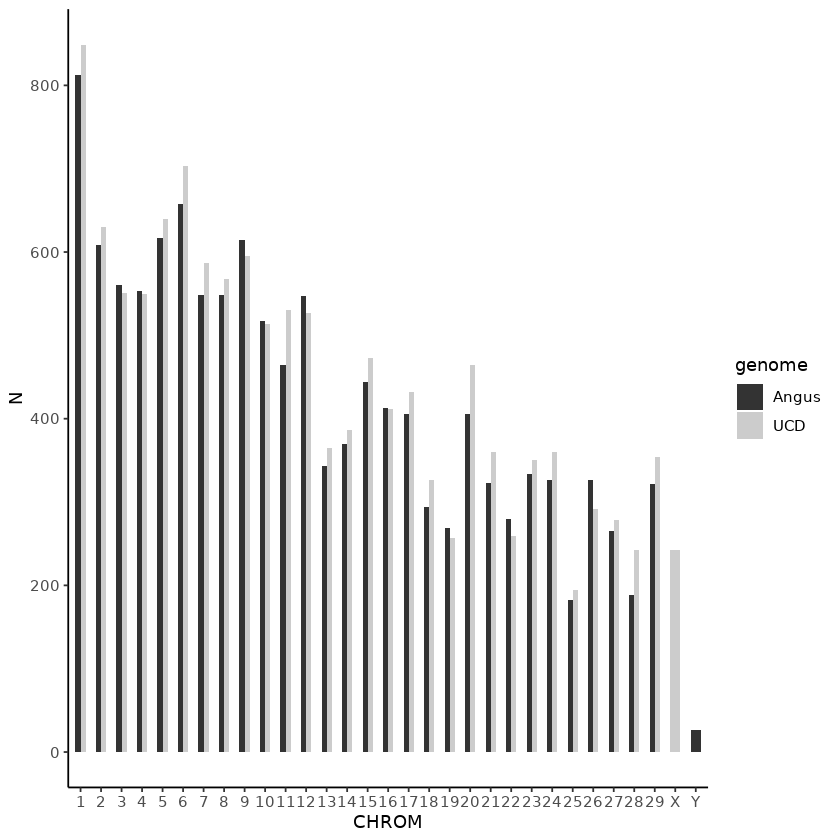

In [7]:
#plot the distribution of the SV across chromosomes in different genome builds
a=UCD[, .(.N), by = .(CHROM)]
b=Angus[, .(.N), by = .(CHROM)]

genome<-rep('UCD',nrow(a))
a2<-cbind(a,genome)
genome<-rep('Angus',nrow(b))
b2<-cbind(b,genome)
w=rbind(a2,b2)

w$CHROM <- factor(w$CHROM,levels = c(seq(1:29),'X','Y'))


ggplot(w, aes(x = CHROM, y= N, fill = genome), xlab="Chromosome") +
geom_bar(stat="identity", width=.5, position = "dodge")+
scale_color_grey()+ scale_fill_grey()+
theme_classic()

#ggsave('sv_n_chrom.pdf',width = 40, height = 20, units = "cm")


In [10]:
#plot sv length
#classify sv by length UCD
#SV < 1kb
x=bind_rows(UCD %>% filter(SVTYPE=="INS") %>% filter(SVLEN<1000) %>% mutate(bin=ceiling(abs(SVLEN)/100)*100) %>% group_by(bin) %>% summarize(count=n()),
            UCD %>% filter(SVTYPE=="DEL") %>% filter(SVLEN>-1000) %>% mutate(bin=ceiling(abs(SVLEN)/100)*100) %>% group_by(bin) %>% summarize(count=n()) %>% mutate(bin=-1*bin))
#SV > lkb
y = bind_rows(UCD %>% filter(SVTYPE=="INS") %>% filter(SVLEN>=1000) %>% mutate(bin=round(abs(SVLEN)/1000)*1000) %>% group_by(bin) %>% summarize(count=n()),
              UCD %>% filter(SVTYPE=="DEL") %>% filter(SVLEN<= -1000) %>% mutate(bin=round(abs(SVLEN)/1000)*1000) %>% group_by(bin) %>% summarize(count=n()) %>% mutate(bin=-1*bin))

#group SV > 10kb into one category
f=with(y,sum(y[bin < -10000, 2]))
y$bin[y$bin <= -11000 ] <- -11000
c=rbind(y %>% filter(bin> -11000),c(-11000,f))
genome=rep('UCD',nrow(x))
x=cbind(x,genome)



#classify sv by length Angus
#SV < 1kb
t1=bind_rows(Angus %>% filter(SVTYPE=="INS") %>% filter(SVLEN<1000) %>% mutate(bin=ceiling(abs(SVLEN)/100)*100) %>% group_by(bin) %>% summarize(count=n()),
            Angus %>% filter(SVTYPE=="DEL") %>% filter(SVLEN>-1000) %>% mutate(bin=ceiling(abs(SVLEN)/100)*100) %>% group_by(bin) %>% summarize(count=n()) %>% mutate(bin=-1*bin))
#SV > lkb
t2 = bind_rows(Angus %>% filter(SVTYPE=="INS") %>% filter(SVLEN>=1000) %>% mutate(bin=round(abs(SVLEN)/1000)*1000) %>% group_by(bin) %>% summarize(count=n()),
              Angus %>% filter(SVTYPE=="DEL") %>% filter(SVLEN<= -1000) %>% mutate(bin=round(abs(SVLEN)/1000)*1000) %>% group_by(bin) %>% summarize(count=n()) %>% mutate(bin=-1*bin))

#group SV > 10kb into one category
f=with(t2,sum(t2[bin < -10000, 2]))
t2$bin[t2$bin <= -11000 ] <- -11000
t3=rbind(t2 %>% filter(bin> -11000),c(-11000,f))
genome=rep('Angus',nrow(t1))
t=cbind(t1,genome)

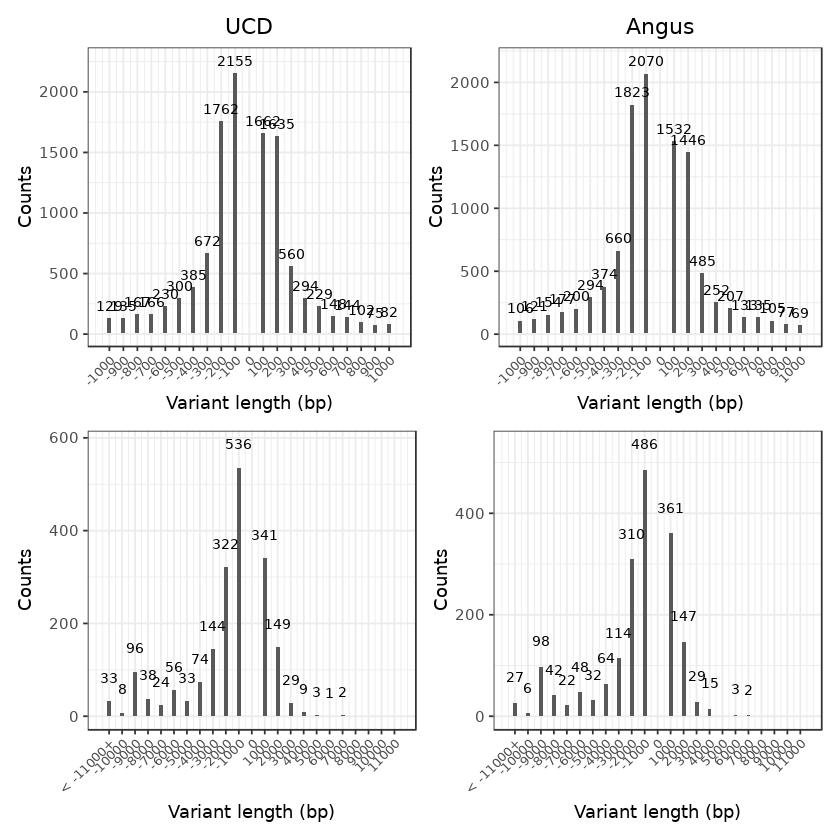

In [11]:
#plot the count of sv < 1kb UCD
m=1.5
#gs=
p1=ggplot() +
  geom_rect(data=x, aes(xmin=bin-10*m,xmax=bin+10*m,ymin=10,ymax=count))+
  geom_text(data=x, aes(x=bin, y=count+100, label=count), size=3) +
  scale_x_continuous(breaks=seq(-1000,1000,100),limits=c(-1050,1050))+
  xlab("Variant length (bp)")+
  ylab("Counts")+
  theme_bw()+
  theme(axis.text.x = element_text(size = 8,angle = 45,hjust = 1))+
  ggtitle("UCD")+
  theme(plot.title = element_text(hjust = 0.5))


#plot the count of sv < 1kb Angus
m=1.5
#gs=
p2=ggplot() +
  geom_rect(data=t1, aes(xmin=bin-10*m,xmax=bin+10*m,ymin=10,ymax=count))+
  geom_text(data=t1, aes(x=bin, y=count+100, label=count), size=3) +
  scale_x_continuous(breaks=seq(-1000,1000,100),limits=c(-1050,1050))+
  xlab("Variant length (bp)")+
  ylab("Counts")+
  theme_bw()+
  theme(axis.text.x = element_text(size = 8,angle = 45,hjust = 1))+
  ggtitle("Angus")+
  theme(plot.title = element_text(hjust = 0.5))




#plot the count of sv > 1kb
n=1.5
p3= ggplot() +
  geom_rect(data=c, aes(xmin=bin-100*n,xmax=bin+100*n,ymin=0,ymax=count))+
  geom_text(data=c, aes(x=bin, y=count+50, label=count), size=3) +
  scale_x_continuous(breaks=seq(-11000,11000,1000),limits=c(-11500,11500),labels=c("< -11000+",seq(-10000,11000, by=1000)))+
  xlab("Variant length (bp)")+
  ylab("Counts")+
  theme_bw()+
  theme(axis.text.x = element_text(size = 8,angle = 45,hjust = 1))

p4= ggplot() +
  geom_rect(data=t3, aes(xmin=bin-100*n,xmax=bin+100*n,ymin=0,ymax=count))+
  geom_text(data=t3, aes(x=bin, y=count+50, label=count), size=3) +
  scale_x_continuous(breaks=seq(-11000,11000,1000),limits=c(-11500,11500),labels=c("< -11000+",seq(-10000,11000, by=1000)))+
  xlab("Variant length (bp)")+
  ylab("Counts")+
  theme_bw()+
  theme(axis.text.x = element_text(size = 8,angle = 45,hjust = 1))

(p1|p2)/
(p3|p4)

ggsave('sv_length.pdf',width = 40, height = 20, units = "cm")


In [12]:
#plot small sv (abs length <1000) from two builds together

s_UCD=auto_UCD[SVLEN %between% c(-1000, 1000) & SVTYPE %in% c('INS','DEL'),c('SVLEN','SVTYPE')]
genome=rep('UCD',nrow(s_UCD))
v=cbind(s_UCD,genome)


s_Angus=auto_angus[SVLEN %between% c(-1000, 1000) & SVTYPE %in% c('INS','DEL'),c('SVLEN','SVTYPE')]
genome=rep('Angus',nrow(s_Angus))
p=cbind(s_Angus,genome)

com=rbind(v,p)

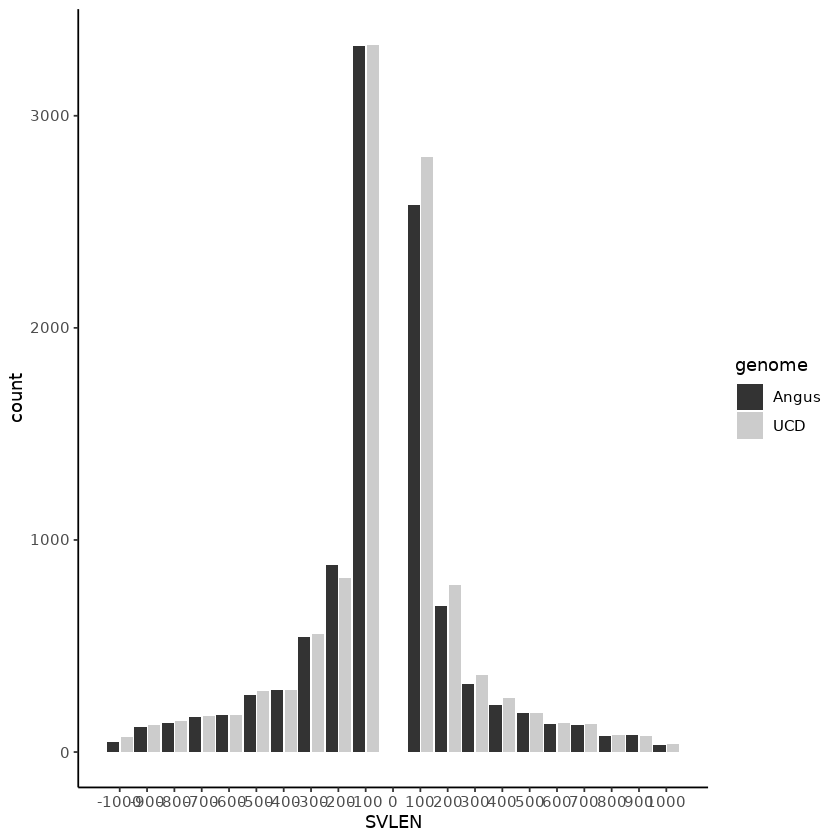

In [13]:
ggplot(com, aes(x = SVLEN, fill=genome)) +
  geom_histogram(binwidth=100,center = 0.5,position = "dodge2")+
  scale_color_grey()+scale_fill_grey() +
  theme_classic()+
  scale_x_continuous(breaks = seq(-1000,1000,100), labels = seq(-1000,1000,100))

  #stat_bin(binwidth=100, geom="text", aes(label=..count..), vjust=-0.5,size=2) 

ggsave('small_sv_length_auto.pdf',width = 40, height = 20, units = "cm")

In [14]:
l_UCD=auto_UCD[(SVLEN > 1000 | SVLEN < -1000)& SVTYPE %in% c('INS','DEL') ,c('SVLEN','SVTYPE')]
genome=rep('UCD',nrow(l_UCD))
q1=cbind(l_UCD,genome)


l_Angus=auto_angus[(SVLEN > 1000 | SVLEN < -1000)& SVTYPE %in% c('INS','DEL') ,c('SVLEN','SVTYPE')]
genome=rep('Angus',nrow(l_Angus))
q2=cbind(l_Angus,genome)

q3=rbind(q1,q2)

q3$SVLEN[q3$SVLEN < -11000]<- -11000

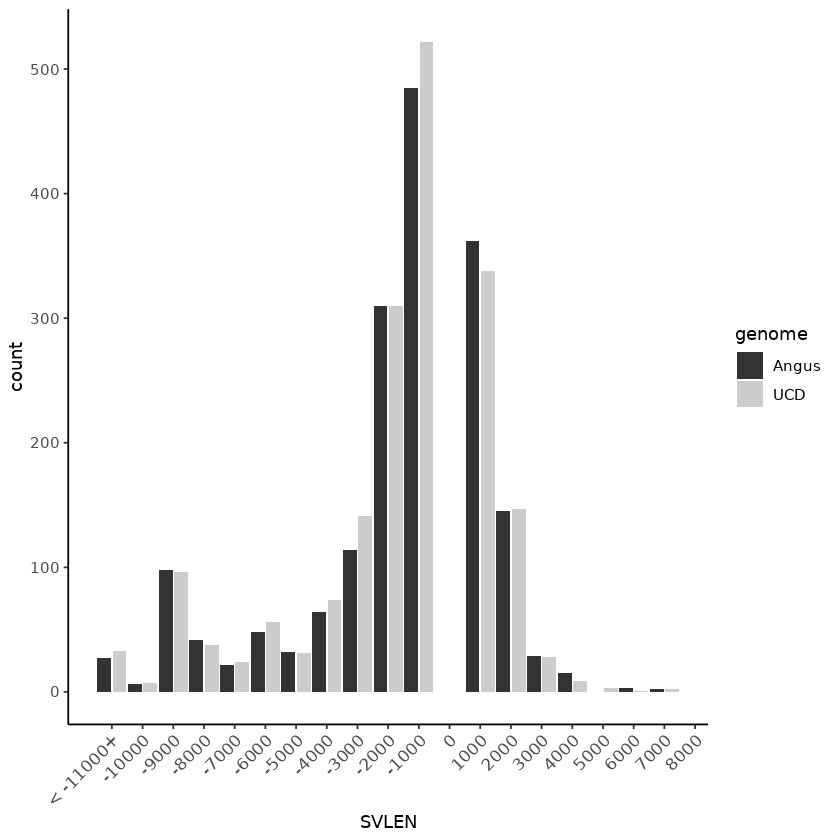

In [15]:
ggplot(q3, aes(x = SVLEN, fill=genome)) +
  geom_histogram(binwidth=1000,center = 0.5,position = "dodge2")+
  scale_color_grey()+scale_fill_grey() +
  theme_classic() +
  scale_x_continuous(breaks=seq(-11000,11000,1000),labels=c("< -11000+",seq(-10000,11000, by=1000)))+
  theme(axis.text.x = element_text(size = 10,angle = 45,hjust = 1))

ggsave('large_sv_length_auto.pdf',width = 40, height = 20, units = "cm")
